In [ ]:
import pandas as pd
import os
from google.colab import drive 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

Mounted at /content/drive


# Bankruptcy Indicators

## Research Company Reason for Deletion (DLRSN)

The Research Company reason for Deletion (DLRSN) is in indicator found in the CRSP/COMPUSTAT Merged Data set and is a numeric field with codes ranging from 01-14. We are primarily interested in the code values equalling 02 (Bankruptcy). However, additionall bankruptcy indicators might be used in the future to supplement this indicator.

### Pure Bankruptcy (DLRSN == 02)

#### Code

In [ ]:
# Create XDataframe
import os
import pandas as pd
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/codeWrappers/dataFrameCreation/')
from createXDataframeWrapper import createXDataFrame
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

# Load Data
CRSP_COMPUSTAT_MERGED = pd.read_csv('Data/Original/CRSP_COMPUSTAT_MERGED.csv')
CRSP_MONTHLY = pd.read_csv('Data/Original/CRSP_MONTHLY.csv')
CRSP_DAILY = pd.read_csv('Data/Original/CRSP_DAILY_REDUCED.csv')
SP500_MONTHLY = pd.read_csv('Data/Original/SP500_MONTHLY.csv')

rawDataframes = [CRSP_COMPUSTAT_MERGED, CRSP_MONTHLY, CRSP_DAILY, SP500_MONTHLY]
xDataFrame = createXDataFrame(rawDataframes, 
                              explanatoryVariablesToCalculate=['NITA', 
                                                      'NIMTA',
                                                      'TLTA',
                                                      'TLMTA',
                                                      'EXRET',
                                                      'RSIZE',
                                                      'CASHMTA',
                                                      'SIGMA'
                                                      ],
                              CRSP_COMPUSTAT_Accounting_features = ['atq', 'ceqq', 'cheq', 'ltq', 'niq', 'dlrsn', 'dldte'],
                              keepAllFeatures=True
                              )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
xDataFrame.head()

,PERMNO,date_month,PRC,SHROUT,CFACPR,RET,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,GVKEY,conm,cik,SIGMA,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA
0,10000,1986-02,-3.25000,3680.0,1.0,-0.257143,1.265,0.689,0.743,0.576,-0.132,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062
1,10000,1986-03,-4.43750,3680.0,1.0,0.365385,1.265,0.689,0.743,0.576,-0.132,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046
2,10000,1986-04,-4.00000,3793.0,1.0,-0.098592,1.265,0.689,0.743,0.576,-0.132,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049
3,10000,1986-05,-3.10938,3793.0,1.0,-0.222656,1.284,0.578,0.395,0.706,-0.484,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.718449,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033
4,10000,1986-06,-3.09375,3793.0,1.0,-0.005025,1.284,0.578,0.395,0.706,-0.484,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.520684,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034


In [ ]:
def bankruptcyWithinNMonths(row, N, filler):
  """
  Check if a Bankruptcy has occured within N months of a given date (month)
  """
  dldte_month = row['dldte_month']
  date_month = row['date_month']
  check_date = date_month+N
  
  bankruptcyOccurs=0
  if check_date>= dldte_month:
    bankruptcyOccurs=1

  return bankruptcyOccurs

# Create Y-Dataframe
yDataFrame = xDataFrame.copy()

# Drop NAs
yDataFrame = yDataFrame.dropna()

#yDataFrame = yDataFrame[:1000]

# Format Deletion Date
yDataFrame['dldte'] = pd.to_datetime(yDataFrame['dldte'])

# Convert Date to Month Period
yDataFrame['dldte_month'] = yDataFrame['dldte'].dt.to_period('m')


monthsWithinBankruptcy = [3, 6, 12, 24, 60]
bankruptcyIndicators = []

for monthLag in monthsWithinBankruptcy:
  # Determine new column name
  colName = f'bankruptcyWithin{monthLag}Months'

  # Append Bankruptcy Indicator to list
  bankruptcyIndicators.append(colName)

  # Initially Fill Columns to 0
  yDataFrame[colName] = 0

  # Update indicator
  #yDataFrame.update(yDataFrame[yDataFrame['dlrsn']==2].apply(bankruptcyWithinNMonths, axis=1, args=(monthLag, 0)))
  yDataFrame.loc[yDataFrame['dlrsn']==2, colName] = yDataFrame[yDataFrame['dlrsn']==2].apply(bankruptcyWithinNMonths, axis=1, args=(monthLag, 0))

# Keep only desired features
featuresToKeep = ['PERMNO', 'GVKEY', 'conm', 'date_month']
featuresToKeep.extend(bankruptcyIndicators)
yDataFrame = yDataFrame[featuresToKeep]
yDataFrame.head()

,PERMNO,GVKEY,conm,date_month,bankruptcyWithin3Months,bankruptcyWithin6Months,bankruptcyWithin12Months,bankruptcyWithin24Months,bankruptcyWithin60Months
3,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-05,0,0,0,0,0
4,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-06,0,0,0,0,0
5,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-07,0,0,0,0,0
6,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-08,0,0,0,0,0
7,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-09,0,0,0,0,0


#### Wrapper

In [ ]:
def bankruptcyWithinNMonths(row, N, filler):
  """
  Check if a Bankruptcy has occured within N months of a given date (month)
  """
  dldte_month = row['dldte_month']
  date_month = row['date_month']
  check_date = date_month+N
  
  bankruptcyOccurs=0
  if check_date>= dldte_month:
    bankruptcyOccurs=1

  return bankruptcyOccurs

def createYDataFrame(xDataFrame, 
                     monthsWithinBankruptcy = [3, 6, 12, 24, 60],
                     dropNA=True,
                     featuresToKeep =['PERMNO', 'GVKEY', 'conm', 'date_month']
                     ):
  """
  Create Y DataFrame
  """
  # Create Y-Dataframe
  yDataFrame = xDataFrame.copy()

  if dropNA:
    # Drop NAs
    yDataFrame = yDataFrame.dropna()

  # Format Deletion Date
  yDataFrame['dldte'] = pd.to_datetime(yDataFrame['dldte'])

  # Convert Date to Month Period
  yDataFrame['dldte_month'] = yDataFrame['dldte'].dt.to_period('m')


  monthsWithinBankruptcy = monthsWithinBankruptcy
  bankruptcyIndicators = []

  for monthLag in monthsWithinBankruptcy:
    # Determine new column name
    colName = f'bankruptcyWithin{monthLag}Months'

    # Append Bankruptcy Indicator to list
    bankruptcyIndicators.append(colName)

    # Initially Fill Columns to 0
    yDataFrame[colName] = 0

    # Update indicator
    #yDataFrame.update(yDataFrame[yDataFrame['dlrsn']==2].apply(bankruptcyWithinNMonths, axis=1, args=(monthLag, 0)))
    yDataFrame.loc[yDataFrame['dlrsn']==2, colName] = yDataFrame[yDataFrame['dlrsn']==2].apply(bankruptcyWithinNMonths, axis=1, args=(monthLag, 0))

  # Keep only desired features
  featuresToKeep = featuresToKeep
  featuresToKeep.extend(bankruptcyIndicators)
  yDataFrame = yDataFrame[featuresToKeep]
  
  return yDataFrame

In [ ]:

import os
import pandas as pd
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/codeWrappers/dataFrameCreation/')
from createXDataframeWrapper import createXDataFrame
from createYDataframeWrapper import createYDataFrame
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

# Load Data
CRSP_COMPUSTAT_MERGED = pd.read_csv('Data/Original/CRSP_COMPUSTAT_MERGED.csv')
CRSP_MONTHLY = pd.read_csv('Data/Original/CRSP_MONTHLY.csv')
CRSP_DAILY = pd.read_csv('Data/Original/CRSP_DAILY_REDUCED.csv')
SP500_MONTHLY = pd.read_csv('Data/Original/SP500_MONTHLY.csv')

# Create XDataframe
rawDataframes = [CRSP_COMPUSTAT_MERGED.copy(), CRSP_MONTHLY.copy(), CRSP_DAILY.copy(), SP500_MONTHLY.copy()]
xDataFrameWithAllFeatures = createXDataFrame(rawDataframes, 
                                             explanatoryVariablesToCalculate=['NITA', 
                                                      'NIMTA',
                                                      'TLTA',
                                                      'TLMTA',
                                                      'EXRET',
                                                      'RSIZE',
                                                      'CASHMTA',
                                                      'SIGMA'
                                                      ],
                              CRSP_COMPUSTAT_Accounting_features = ['atq', 'ceqq', 'cheq', 'ltq', 'niq', 'dlrsn', 'dldte'],
                              keepAllFeatures=True
                              )
                              

# Create Y DataFrame
yDataFrame = createYDataFrame(xDataFrame = xDataFrameWithAllFeatures.copy(), 
                              monthsWithinBankruptcy = [3, 6, 12, 24, 60],
                              dropNA=False
                              )


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In


In [ ]:
CRSP_COMPUSTAT_MERGED['costat']

0          I
1          I
2          I
3          I
4          I
          ..
1144360    A
1144361    A
1144362    A
1144363    A
1144364    A
Name: costat, Length: 1144365, dtype: object

In [ ]:
yDataFrame.head()

,PERMNO,GVKEY,conm,date_month,bankruptcyWithin3Months,bankruptcyWithin6Months,bankruptcyWithin12Months,bankruptcyWithin24Months,bankruptcyWithin60Months
0,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-02,0,0,0,0,0
1,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-03,0,0,0,0,0
2,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-04,0,0,0,0,0
3,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-05,0,0,0,0,0
4,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-06,0,0,0,0,0


In [ ]:
yDataFrame.shape

(2600008, 14)

In [ ]:
yDataFrame['bankruptcyWithin3Months'].sum()

bankruptcyWithin3Months    87
bankruptcyWithin3Months    87
dtype: int64

## Bloomberg Bankruptcy Data

### Code

In [ ]:
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/codeWrappers/dataFrameCreation/')
from bloombergDataFormatWrapper import formatBloombergBankruptcyData
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

bloombergData = pd.read_csv('Data/Bloomberg/Bloomberg_bankruptcies_COMPLETE.csv')

# Drop NaN
bloombergData = bloombergData.dropna()

# Rename Columns
bloombergData = bloombergData.rename(columns={'Summary1': 'companyName', 'Summary': 'filingType'})
bloombergData = formatBloombergBankruptcyData(bloombergData, filterPublicCompanies=True)
bloombergData['companyName'] = bloombergData['companyName'].map(lambda x: x.upper())

# Format Effective Date Field and Add month field
bloombergData['Effective Date'] = pd.to_datetime(bloombergData['Effective Date'])
bloombergData['effectiveDate_Bloomberg_date_month'] = bloombergData['Effective Date'].dt.to_period('M')

# Filter to Only Public Firms and bankruptcy (Chpater 11 or 7)
bloombergData = bloombergData[(bloombergData['isPublic']==1) &
                              (bloombergData['filingType'].isin(['Chapter 11', 'Chapter 7']))
                              ]

# Drop Duplicate Companies Listed
bloombergData = bloombergData.drop_duplicates(subset=['companyName'])
bloombergData.head()

,companyID,companyName,Announce/Declared Date,Effective Date,filingType,isPublic,effectiveDate_Bloomberg_date_month
0,AITTQ,AIRLIFT INTERNATIONAL INC,1981-06-04,1981-06-04,Chapter 11,1,1981-06
2,RAY,RAYTECH CORP-DEL,1989-03-10,1989-03-10,Chapter 11,1,1989-03
3,WJIM,JIM WALTER CORP,1989-12-27,1989-12-27,Chapter 11,1,1989-12
4,BKNEO,BANK OF NEW ENGLAND CORP,1991-01-07,1991-01-07,Chapter 7,1,1991-01
5,NWXJ,NEWAX INC,1991-05-30,1991-05-30,Chapter 11,1,1991-05


In [ ]:
BloombergAfterMerge = pd.merge(xDataFrame.copy(),
         bloombergData.copy(),
         how='left',
         left_on=['conm'],
         right_on=['companyName']
         )
BloombergAfterMerge.head()

,PERMNO,date_month,PRC,SHROUT,CFACPR,RET,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,GVKEY,conm,cik,SIGMA,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,companyID,companyName,Announce/Declared Date,Effective Date,filingType,isPublic,effectiveDate_Bloomberg_date_month
0,10000,1986-02,-3.25000,3680.0,1.0,-0.257143,1.265,0.689,0.743,0.576,-0.132,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,NaN,NaN,NaT,NaT,NaN,NaN,NaT
1,10000,1986-03,-4.43750,3680.0,1.0,0.365385,1.265,0.689,0.743,0.576,-0.132,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,NaN,NaN,NaT,NaT,NaN,NaN,NaT
2,10000,1986-04,-4.00000,3793.0,1.0,-0.098592,1.265,0.689,0.743,0.576,-0.132,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,NaN,NaN,NaT,NaT,NaN,NaN,NaT
3,10000,1986-05,-3.10938,3793.0,1.0,-0.222656,1.284,0.578,0.395,0.706,-0.484,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.718449,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,NaN,NaN,NaT,NaT,NaN,NaN,NaT
4,10000,1986-06,-3.09375,3793.0,1.0,-0.005025,1.284,0.578,0.395,0.706,-0.484,10.0,09/30/1989,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.520684,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,NaN,NaN,NaT,NaT,NaN,NaN,NaT


In [ ]:
print(xDataFrame.shape)
print(xDataFrame.drop_duplicates(['conm', 'date_month']).shape)

(2600008, 25)
(2097843, 25)


In [ ]:
xDataFrame = xDataFrame.drop_duplicates(['conm', 'date_month'])

In [ ]:
print('Original XDataframe Number of Bankruptcies: ', len(xDataFrame[xDataFrame['dlrsn']==2].drop_duplicates(['PERMNO'])))
print('Bloomberg Number of Bankruptcies (before merge on Company Name): ', len(bloombergData.drop_duplicates(['companyName'])) )
print('Bloomberg Number of Bankruptcies (after merge on Company Name): ', len(BloombergAfterMerge.dropna(subset=['isPublic']).drop_duplicates(['PERMNO'])) )


Original XDataframe Number of Bankruptcies:  594
Bloomberg Number of Bankruptcies (before merge on Company Name):  1574
Bloomberg Number of Bankruptcies (after merge on Company Name):  605


## Audit Analytics

### Code

In [ ]:
AUDIT_ANALYTICS = pd.read_csv('Data/Original/AUDIT_ANALYTICS.csv')
print(AUDIT_ANALYTICS.shape)

def formatFileData(FILE_DATE):
  FILE_DATE = str(FILE_DATE)
  FILE_DATE = FILE_DATE[:4] + '-' + FILE_DATE[4:6] + '-' + FILE_DATE[6:8]
  return FILE_DATE

# Drop NAs (only three)
AUDIT_ANALYTICS = AUDIT_ANALYTICS.dropna(subset=['FILE_DATE'])

# Convert float to string readable date
AUDIT_ANALYTICS['FILE_DATE'] = AUDIT_ANALYTICS['FILE_DATE'].map(formatFileData)

# Convert to Datetime Object
AUDIT_ANALYTICS['FILE_DATE'] = pd.to_datetime(AUDIT_ANALYTICS['FILE_DATE'], format='%Y-%m-%d')

# Add month period
AUDIT_ANALYTICS['fileDate_AuditAnalytics_month'] = AUDIT_ANALYTICS['FILE_DATE'].dt.to_period('M')

# Filter Bankruptcy Type to be 7 or 11
AUDIT_ANALYTICS = AUDIT_ANALYTICS[AUDIT_ANALYTICS['BANKRUPTCY_TYPE'].isin([7, 11])]

# Add Column Bankruptcy_Type
AUDIT_ANALYTICS = AUDIT_ANALYTICS.drop_duplicates('COMPANY_FKEY')
print(AUDIT_ANALYTICS.shape)
AUDIT_ANALYTICS.head()

(2906, 5)
(2830, 6)


,BANKRUPTCY_TYPE,BANK_BEGIN_DATE,BANK_END_DATE,FILE_DATE,COMPANY_FKEY,fileDate_AuditAnalytics_month
0,11,2019-02-19,NaN,2019-09-20,2034,2019-09
1,11,2017-04-21,NaN,2017-04-24,2178,2017-04
2,11,2002-10-01,2013-01-09,2002-10-15,2852,2002-10
3,11,2020-05-20,NaN,2020-05-21,3116,2020-05
4,11,2001-02-06,2006-07-31,2001-02-20,3662,2001-02


# New Section

## Combined Indicators (Bloomberg + DLRSN(02))

# Analyze Results

## Format Data to Analyze

### DLRSN

In [ ]:
# Format Deletion Date Field and add Month Period
xDataFrame['dldte'] = pd.to_datetime(xDataFrame['dldte'])
xDataFrame['dldte_month'] = xDataFrame['dldte'].dt.to_period('M')

# Copy X-DataFrame
DLRSN_Analysis = xDataFrame.copy()

# Keep only firms that went bankrupt (dlrsn==2) keep those firms only once
DLRSN_Analysis = DLRSN_Analysis[DLRSN_Analysis['dlrsn']==2].drop_duplicates(subset=['PERMNO'])[['PERMNO', 'dldte_month']]

# Convert Month Field to Year (int)
DLRSN_Analysis['year'] = DLRSN_Analysis['dldte_month'].map(lambda x: int(str(x)[:4]))

# Count number of bankruptcies Per Year
DLRSN_Analysis = DLRSN_Analysis.groupby(['year'])['PERMNO'].count()

### Bloomberg Bankruptcy Data (Before Merge)

In [ ]:
# Copy Dataframe
BloombergBeforeMergeAnalysis = bloombergData.copy()

# Format Deletion Date Field and add Month Period
BloombergBeforeMergeAnalysis['date_month'] = BloombergBeforeMergeAnalysis['Effective Date'].dt.to_period('M')

# Convert Month Field to Year (int)
BloombergBeforeMergeAnalysis['year'] = BloombergBeforeMergeAnalysis['date_month'].map(lambda x: int(str(x)[:4]))

# Count number of bankruptcies Per Year
BloombergBeforeMergeAnalysis = BloombergBeforeMergeAnalysis.groupby(['year'])['companyName'].count()

### Bloomberg Bankruptcy Data (After Merge)

In [ ]:
# Create Copy of Dataframe
BloombergAfterMergeAnalysis = BloombergAfterMerge.copy()

# Drop all NAs that appear after merge (ie any company that could not merge with the XDataframe)
BloombergAfterMergeAnalysis = BloombergAfterMergeAnalysis.dropna(subset=['companyName'])

# Format Deletion Date Field and add Month Period
BloombergAfterMergeAnalysis['Effective Date'] = pd.to_datetime(BloombergAfterMergeAnalysis['Effective Date'])
BloombergAfterMergeAnalysis['dldte_month'] = BloombergAfterMergeAnalysis['Effective Date'].dt.to_period('M')

# Convert Month Field to Year (int)
BloombergAfterMergeAnalysis['year'] = BloombergAfterMergeAnalysis['dldte_month'].map(lambda x: int(str(x)[:4]))

# Keep firm appearnce to 1
BloombergAfterMergeAnalysis = BloombergAfterMergeAnalysis.drop_duplicates(subset=['PERMNO'], keep='last')[['PERMNO', 'year']]

# Count number of bankruptcies Per Year
BloombergAfterMergeAnalysis = BloombergAfterMergeAnalysis.groupby(['year'])['PERMNO'].count()

### Audit Analytics Data (Before Merge)

In [ ]:
# Copy Dataframe
AUDIT_ANALYTICS_beforeMerge = AUDIT_ANALYTICS.copy()

def formatFileData(FILE_DATE):
  FILE_DATE = str(FILE_DATE)
  FILE_DATE = FILE_DATE[:4] + '-' + FILE_DATE[4:6] + '-' + FILE_DATE[6:8]
  return FILE_DATE

# Drop NAs (only three)
AUDIT_ANALYTICS_beforeMerge = AUDIT_ANALYTICS_beforeMerge.dropna(subset=['FILE_DATE'])

# Convert float to string readable date
AUDIT_ANALYTICS_beforeMerge['FILE_DATE'] = AUDIT_ANALYTICS_beforeMerge['FILE_DATE'].map(formatFileData)

# Convert to Datetime Object
AUDIT_ANALYTICS_beforeMerge['FILE_DATE'] = pd.to_datetime(AUDIT_ANALYTICS_beforeMerge['FILE_DATE'], format='%Y-%m-%d')

# Add month period
AUDIT_ANALYTICS_beforeMerge['FILE_DATE_month'] = AUDIT_ANALYTICS_beforeMerge['FILE_DATE'].dt.to_period('M')

# Convert Month Field to Year (int)
AUDIT_ANALYTICS_beforeMerge['FILE_DATE_year'] = AUDIT_ANALYTICS_beforeMerge['FILE_DATE_month'].map(lambda x: int(str(x)[:4]))

# Keep firm appearnce to 1
AUDIT_ANALYTICS_beforeMerge = AUDIT_ANALYTICS_beforeMerge.drop_duplicates(subset=['COMPANY_FKEY'], keep='last')[['COMPANY_FKEY', 'FILE_DATE_year']]

# Count number of bankruptcies Per Year
AUDIT_ANALYTICS_beforeMerge = AUDIT_ANALYTICS_beforeMerge.groupby(['FILE_DATE_year'])['COMPANY_FKEY'].count()

AUDIT_ANALYTICS_beforeMerge.plot()

ValueError: ignored

In [ ]:
AUDIT_ANALYTICS.head()

,BANKRUPTCY_TYPE,BANK_BEGIN_DATE,BANK_END_DATE,FILE_DATE,COMPANY_FKEY,fileDate_AuditAnalytics_month
0,11,2019-02-19,NaN,2019-09-20,2034,2019-09
1,11,2017-04-21,NaN,2017-04-24,2178,2017-04
2,11,2002-10-01,2013-01-09,2002-10-15,2852,2002-10
3,11,2020-05-20,NaN,2020-05-21,3116,2020-05
4,11,2001-02-06,2006-07-31,2001-02-20,3662,2001-02


### Audit Analytics Data (After Merge)

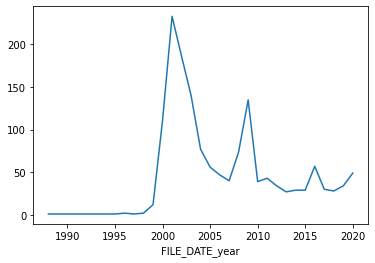

In [ ]:
# Copy Dataframe
AUDIT_ANALYTICS_afterMerge = AUDIT_ANALYTICS.copy()

def formatFileData(FILE_DATE):
  FILE_DATE = str(FILE_DATE)
  FILE_DATE = FILE_DATE[:4] + '-' + FILE_DATE[4:6] + '-' + FILE_DATE[6:8]
  return FILE_DATE

# Drop NAs (only three)
AUDIT_ANALYTICS_afterMerge = AUDIT_ANALYTICS_afterMerge.dropna(subset=['FILE_DATE'])

# Convert float to string readable date
#AUDIT_ANALYTICS_afterMerge['FILE_DATE'] = AUDIT_ANALYTICS_afterMerge['FILE_DATE'].map(formatFileData)

# Convert to Datetime Object
#AUDIT_ANALYTICS_afterMerge['FILE_DATE'] = pd.to_datetime(AUDIT_ANALYTICS_afterMerge['FILE_DATE'], format='%Y-%m-%d')

# Add month period
AUDIT_ANALYTICS_afterMerge['FILE_DATE_month'] = AUDIT_ANALYTICS_afterMerge['FILE_DATE'].dt.to_period('M')

# Convert Month Field to Year (int)
AUDIT_ANALYTICS_afterMerge['FILE_DATE_year'] = AUDIT_ANALYTICS_afterMerge['FILE_DATE_month'].map(lambda x: int(str(x)[:4]))

# Keep firm appearnce to 1
AUDIT_ANALYTICS_afterMerge = AUDIT_ANALYTICS_afterMerge.drop_duplicates(subset=['COMPANY_FKEY'], keep='last')[['COMPANY_FKEY', 'FILE_DATE_month', 'BANKRUPTCY_TYPE']]

# Merge with bloombergAfterMerge
AUDIT_ANALYTICS_afterMerge = pd.merge(xDataFrame.copy(),
         AUDIT_ANALYTICS_afterMerge.copy(),
         how='left',
         left_on=['cik'],
         right_on=['COMPANY_FKEY']
         )

# Drop NaN for missing file dates (only for plotting purposes)
AUDIT_ANALYTICS_afterMerge = AUDIT_ANALYTICS_afterMerge.dropna(subset=['FILE_DATE_month'])

# Convert Month Field to Year (int)
AUDIT_ANALYTICS_afterMerge['FILE_DATE_year'] = AUDIT_ANALYTICS_afterMerge['FILE_DATE_month'].map(lambda x: int(str(x)[:4]))

# Keep firm appearnce to 1
AUDIT_ANALYTICS_afterMerge = AUDIT_ANALYTICS_afterMerge.drop_duplicates(subset=['PERMNO'], keep='last')[['PERMNO', 'FILE_DATE_year']]

# Count number of bankruptcies Per Year
AUDIT_ANALYTICS_afterMerge = AUDIT_ANALYTICS_afterMerge.groupby(['FILE_DATE_year'])['PERMNO'].count()

AUDIT_ANALYTICS_afterMerge.plot()

## Combined Indicators

In [ ]:
bloombergData.head()

,companyID,companyName,Announce/Declared Date,Effective Date,filingType,isPublic,effectiveDate_Bloomberg_date_month
0,AITTQ,AIRLIFT INTERNATIONAL INC,1981-06-04,1981-06-04,Chapter 11,1,1981-06
2,RAY,RAYTECH CORP-DEL,1989-03-10,1989-03-10,Chapter 11,1,1989-03
3,WJIM,JIM WALTER CORP,1989-12-27,1989-12-27,Chapter 11,1,1989-12
4,BKNEO,BANK OF NEW ENGLAND CORP,1991-01-07,1991-01-07,Chapter 7,1,1991-01
5,NWXJ,NEWAX INC,1991-05-30,1991-05-30,Chapter 11,1,1991-05


### Bloomberg Data

In [ ]:
bloombergDataMerged = pd.merge(xDataFrame.copy(),
         bloombergData.copy()[['companyName', 'effectiveDate_Bloomberg_date_month']],
         how='left',
         left_on=['conm'],
         right_on=['companyName']
         )
#bloombergDataMerged = bloombergDataMerged.drop(columns=['companyName'])
bloombergDataMerged.head()

,PERMNO,date_month,PRC,SHROUT,CFACPR,RET,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,GVKEY,conm,cik,SIGMA,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,dldte_month,companyName,effectiveDate_Bloomberg_date_month
0,10000,1986-02,-3.25000,3680.0,1.0,-0.257143,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,1989-09,NaN,NaT
1,10000,1986-03,-4.43750,3680.0,1.0,0.365385,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,1989-09,NaN,NaT
2,10000,1986-04,-4.00000,3793.0,1.0,-0.098592,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,1989-09,NaN,NaT
3,10000,1986-05,-3.10938,3793.0,1.0,-0.222656,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.718449,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,1989-09,NaN,NaT
4,10000,1986-06,-3.09375,3793.0,1.0,-0.005025,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.520684,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,1989-09,NaN,NaT


### Audit Data

In [ ]:
auditDataMerged = pd.merge(xDataFrame.copy(),
         AUDIT_ANALYTICS.copy()[['COMPANY_FKEY', 'fileDate_AuditAnalytics_month']],
         how='left',
         left_on=['cik'],
         right_on=['COMPANY_FKEY']
         )
#auditDataMerged = auditDataMerged.drop(columns=['COMPANY_FKEY'])
auditDataMerged.head()

,PERMNO,date_month,PRC,SHROUT,CFACPR,RET,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,GVKEY,conm,cik,SIGMA,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,dldte_month,COMPANY_FKEY,fileDate_AuditAnalytics_month
0,10000,1986-02,-3.25000,3680.0,1.0,-0.257143,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,1989-09,NaN,NaT
1,10000,1986-03,-4.43750,3680.0,1.0,0.365385,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,1989-09,NaN,NaT
2,10000,1986-04,-4.00000,3793.0,1.0,-0.098592,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,1989-09,NaN,NaT
3,10000,1986-05,-3.10938,3793.0,1.0,-0.222656,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.718449,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,1989-09,NaN,NaT
4,10000,1986-06,-3.09375,3793.0,1.0,-0.005025,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.520684,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,1989-09,NaN,NaT


### Combined Indicator

In [ ]:
combinedIndicator = pd.merge(bloombergDataMerged.copy(),
                             auditDataMerged.copy()[['PERMNO', 'date_month', 'COMPANY_FKEY', 'fileDate_AuditAnalytics_month']],
                             how='inner',
                             left_on=['PERMNO', 'date_month'],
                             right_on=['PERMNO', 'date_month']
                             )
combinedIndicator.head()

,PERMNO,date_month,PRC,SHROUT,CFACPR,RET,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,GVKEY,conm,cik,SIGMA,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,dldte_month,companyName,effectiveDate_Bloomberg_date_month,COMPANY_FKEY,fileDate_AuditAnalytics_month
0,10000,1986-02,-3.25000,3680.0,1.0,-0.257143,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,1989-09,NaN,NaT,NaN,NaT
1,10000,1986-03,-4.43750,3680.0,1.0,0.365385,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,1989-09,NaN,NaT,NaN,NaT
2,10000,1986-04,-4.00000,3793.0,1.0,-0.098592,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,1989-09,NaN,NaT,NaN,NaT
3,10000,1986-05,-3.10938,3793.0,1.0,-0.222656,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.718449,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,1989-09,NaN,NaT,NaN,NaT
4,10000,1986-06,-3.09375,3793.0,1.0,-0.005025,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.520684,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,1989-09,NaN,NaT,NaN,NaT


In [ ]:
print(combinedIndicator['date_month'].min())
print(combinedIndicator['date_month'].max())
print(combinedIndicator.shape)
print(combinedIndicator.isna().sum())

1960-01
2019-12
(2600014, 31)
PERMNO                                      0
date_month                                  0
PRC                                         0
SHROUT                                      0
CFACPR                                      0
RET                                         0
atq                                    702966
ceqq                                   638973
cheq                                   715679
ltq                                    710403
niq                                    519483
dlrsn                                 1195857
dldte                                 1195857
GVKEY                                  499136
conm                                   499136
cik                                    652930
SIGMA                                  121945
vwretdSP500                                 0
totvalSP500                                 0
NITA                                   716536
NIMTA                                  714826
TLTA

In [ ]:
# Copy Dataframe
combinedIndicators = combinedIndicator.copy()

# Set default value of bankruptcy Indicator Column (0 --> no bankruptcy occured)
combinedIndicators['bankruptcyIndicator'] = 0

# Bankruptcy Occured in firms history if dlrsn == 2
combinedIndicators.loc[combinedIndicators['dlrsn']==2, 'bankruptcyIndicator'] = 1

# Bankruptcy Occured in firms history if they were present in bloomberg dataset
combinedIndicators.loc[~(combinedIndicators['companyName']).isna(), 'bankruptcyIndicator'] = 1

# Bankruptcy Occured in firms history if they were present in Audit Analytics Dataset
combinedIndicators.loc[~(combinedIndicators['COMPANY_FKEY']).isna(), 'bankruptcyIndicator'] = 1

# Format Dates
combinedIndicators['dldte'] = pd.to_datetime(combinedIndicators['dldte'])
#combinedIndicators['effectiveDate_Bloomberg_date_month'] = pd.to_datetime(combinedIndicators['Effective Date'])
combinedIndicators['dldte_month'] = combinedIndicators['dldte'].dt.to_period('M')
#combinedIndicators['Effective Date_month'] = combinedIndicators['Effective Date'].dt.to_period('M')

# Calculate Effective Date of Bankruptcy (Default is Effective Date_month)
combinedIndicators['bankruptcyDate'] = combinedIndicators['effectiveDate_Bloomberg_date_month']
combinedIndicators['bankruptcyDate'] = combinedIndicators['bankruptcyDate'].fillna(combinedIndicators['fileDate_AuditAnalytics_month'])
combinedIndicators['bankruptcyDate'] = combinedIndicators['bankruptcyDate'].fillna(combinedIndicators['dldte_month'])
combinedIndicators.head()

,PERMNO,date_month,PRC,SHROUT,CFACPR,RET,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,GVKEY,conm,cik,SIGMA,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,dldte_month,companyName,effectiveDate_Bloomberg_date_month,COMPANY_FKEY,fileDate_AuditAnalytics_month,bankruptcyIndicator,bankruptcyDate
0,10000,1986-02,-3.25000,3680.0,1.0,-0.257143,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,1989-09,NaN,NaT,NaN,NaT,0,1989-09
1,10000,1986-03,-4.43750,3680.0,1.0,0.365385,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,1989-09,NaN,NaT,NaN,NaT,0,1989-09
2,10000,1986-04,-4.00000,3793.0,1.0,-0.098592,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,NaN,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,1989-09,NaN,NaT,NaN,NaT,0,1989-09
3,10000,1986-05,-3.10938,3793.0,1.0,-0.222656,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.718449,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,1989-09,NaN,NaT,NaN,NaT,0,1989-09
4,10000,1986-06,-3.09375,3793.0,1.0,-0.005025,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,13007.0,OPTIMUM MANUFACTURING -CL A,NaN,0.520684,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,1989-09,NaN,NaT,NaN,NaT,0,1989-09


# New Section

In [ ]:
combinedIndicators.columns

Index(['PERMNO', 'date_month', 'PRC', 'SHROUT', 'CFACPR', 'RET', 'atq', 'ceqq',
       'cheq', 'ltq', 'niq', 'dlrsn', 'dldte', 'GVKEY', 'conm', 'cik', 'SIGMA',
       'vwretdSP500', 'totvalSP500', 'NITA', 'NIMTA', 'TLTA', 'TLMTA', 'EXRET',
       'RSIZE', 'CASHMTA', 'dldte_month', 'companyName',
       'effectiveDate_Bloomberg_date_month', 'COMPANY_FKEY',
       'fileDate_AuditAnalytics_month', 'bankruptcyIndicator',
       'bankruptcyDate'],
      dtype='object')

In [ ]:
finalDF = combinedIndicators.copy()[['PERMNO', 
                           'date_month', 
                           'GVKEY',
                           'cik',
                           'conm',
                           'atq',
                           'ceqq',
                           'cheq',
                           'ltq',
                           'niq',
                           'dlrsn',
                           'dldte',
                           'PRC',
                           'RET',
                           'SHROUT',
                           'CFACPR',
                           'vwretdSP500',
                           'totvalSP500',
                           'NITA',
                           'NIMTA',
                           'TLTA',
                           'TLMTA',
                           'EXRET',
                           'RSIZE',
                           'CASHMTA',
                           'SIGMA',
                           'effectiveDate_Bloomberg_date_month',
                           'fileDate_AuditAnalytics_month',
                           'bankruptcyIndicator',
                           'bankruptcyDate'
                           ]]
finalDF = finalDF.drop_duplicates(subset=['PERMNO', 'date_month'])

In [ ]:
print(finalDF['date_month'].min())
print(finalDF['date_month'].max())
print(finalDF.shape)
print(finalDF.isna().sum())

1960-01
2019-12
(2600005, 30)
PERMNO                                      0
date_month                                  0
GVKEY                                  499136
cik                                    652927
conm                                   499136
atq                                    702966
ceqq                                   638973
cheq                                   715679
ltq                                    710403
niq                                    519483
dlrsn                                 1195857
dldte                                 1195857
PRC                                         0
RET                                         0
SHROUT                                      0
CFACPR                                      0
vwretdSP500                                 0
totvalSP500                                 0
NITA                                   716536
NIMTA                                  714826
TLTA                                   719055
TLMT

In [ ]:
finalDF.to_csv('Data/finalDataframe.csv')

In [ ]:
combinedIndicators = combinedIndicators.drop_duplicates(subset=['PERMNO', 'date_month'])
print(combinedIndicators['date_month'].min())
print(combinedIndicators['date_month'].max())
print(combinedIndicators.shape)
print(combinedIndicators.isna().sum())

1960-01
2019-12
(2600005, 33)
PERMNO                                      0
date_month                                  0
PRC                                         0
SHROUT                                      0
CFACPR                                      0
RET                                         0
atq                                    702966
ceqq                                   638973
cheq                                   715679
ltq                                    710403
niq                                    519483
dlrsn                                 1195857
dldte                                 1195857
GVKEY                                  499136
conm                                   499136
cik                                    652927
SIGMA                                  121945
vwretdSP500                                 0
totvalSP500                                 0
NITA                                   716536
NIMTA                                  714826
TLTA

In [ ]:
# Copy Dataframe
combinedIndicators = combinedIndicator[['PERMNO', 'date_month', 'dlrsn', 'dldte', 'companyName', 'effectiveDate_Bloomberg_date_month', 'COMPANY_FKEY', 'fileDate_AuditAnalytics_month']].copy()

# Set default value of bankruptcy Indicator Column (0 --> no bankruptcy occured)
combinedIndicators['bankruptcyIndicator'] = 0

# Bankruptcy Occured in firms history if dlrsn == 2
combinedIndicators.loc[combinedIndicators['dlrsn']==2, 'bankruptcyIndicator'] = 1

# Bankruptcy Occured in firms history if they were present in bloomberg dataset
combinedIndicators.loc[~(combinedIndicators['companyName']).isna(), 'bankruptcyIndicator'] = 1

# Bankruptcy Occured in firms history if they were present in Audit Analytics Dataset
combinedIndicators.loc[~(combinedIndicators['COMPANY_FKEY']).isna(), 'bankruptcyIndicator'] = 1

# Format Dates
combinedIndicators['dldte'] = pd.to_datetime(combinedIndicators['dldte'])
#combinedIndicators['effectiveDate_Bloomberg_date_month'] = pd.to_datetime(combinedIndicators['Effective Date'])
combinedIndicators['dldte_month'] = combinedIndicators['dldte'].dt.to_period('M')
#combinedIndicators['Effective Date_month'] = combinedIndicators['Effective Date'].dt.to_period('M')

# Calculate Effective Date of Bankruptcy (Default is Effective Date_month)
combinedIndicators['bankruptcyDate'] = combinedIndicators['effectiveDate_Bloomberg_date_month']
combinedIndicators['bankruptcyDate'] = combinedIndicators['bankruptcyDate'].fillna(combinedIndicators['fileDate_AuditAnalytics_month'])
combinedIndicators['bankruptcyDate'] = combinedIndicators['bankruptcyDate'].fillna(combinedIndicators['dldte_month'])


In [ ]:
# View only firms that went bankrupt
combinedIndicatorsAnalysis = combinedIndicators[combinedIndicators['bankruptcyIndicator']==1][['PERMNO', 'bankruptcyDate']].copy()

# Keep firms only once
combinedIndicatorsAnalysis = combinedIndicatorsAnalysis.drop_duplicates(subset=['PERMNO'], keep='last')

# Drop Firms with No Deletion Date
#combinedIndicatorsAnalysis = combinedIndicatorsAnalysis.dropna(subset=['bankruptcyDate'])

# Convert Month Field to Year (int)
combinedIndicatorsAnalysis['year'] = combinedIndicatorsAnalysis['bankruptcyDate'].map(lambda x: int(str(x)[:4]))

# Count number of bankruptcies Per Year
combinedIndicatorsAnalysis = combinedIndicatorsAnalysis.groupby(['year'])['PERMNO'].count()

### Paper Data

In [ ]:
paperData = pd.read_csv('Data/Original/paperData.csv')
paperData = paperData.set_index(['year'])

## Plotting

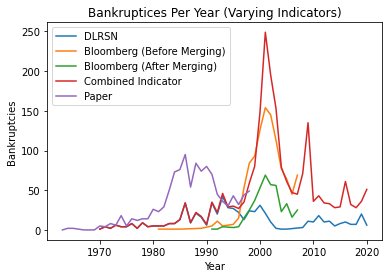

In [ ]:
plt.plot(DLRSN_Analysis, label='DLRSN')
plt.plot(BloombergBeforeMergeAnalysis, label='Bloomberg (Before Merging)')
plt.plot(BloombergAfterMergeAnalysis, label='Bloomberg (After Merging)')
plt.plot(combinedIndicatorsAnalysis, label='Combined Indicator')
plt.plot(paperData['bankruptcies'], label='Paper')
plt.xlabel("Year")
plt.ylabel("Bankruptcies")
plt.title('Bankruptices Per Year (Varying Indicators)')
plt.legend()
plt.show()

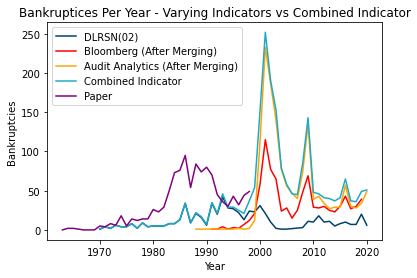

In [ ]:
plt.plot(DLRSN_Analysis, label='DLRSN(02)', color=(0,64/255,106/255,255/255))
#plt.plot(BloombergBeforeMergeAnalysis, label='Bloomberg (Before Merging)')
plt.plot(BloombergAfterMergeAnalysis, label='Bloomberg (After Merging)', color='r')
plt.plot(AUDIT_ANALYTICS_afterMerge, label='Audit Analytics (After Merging)', color='orange')
plt.plot(combinedIndicatorsAnalysis, label='Combined Indicator', color=(30/255,170/255,198/255,255/255))
plt.plot(paperData['bankruptcies'], label='Paper', color='purple')
#plt.plot(paperData['bankruptcies'], label='Paper')
plt.xlabel("Year")
plt.ylabel("Bankruptcies")
plt.title('Bankruptices Per Year - Varying Indicators vs Combined Indicator')
plt.legend()
plt.savefig('images/VaryingIndicatorsVScombinedIndicator.png')
plt.show()

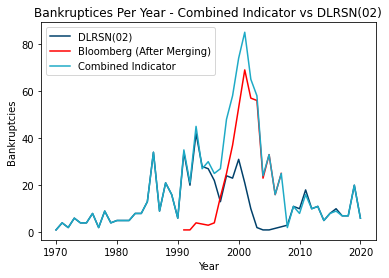

In [ ]:
plt.plot(DLRSN_Analysis, label='DLRSN(02)', color=(0,64/255,106/255,255/255))
#plt.plot(BloombergBeforeMergeAnalysis, label='Bloomberg (Before Merging)')
plt.plot(BloombergAfterMergeAnalysis, label='Bloomberg (After Merging)', color='r')
plt.plot(combinedIndicatorsAnalysis, label='Combined Indicator', color=(30/255,170/255,198/255,255/255))

#plt.plot(paperData['bankruptcies'], label='Paper')
plt.xlabel("Year")
plt.ylabel("Bankruptcies")
plt.title('Bankruptices Per Year - Combined Indicator vs DLRSN(02)')
plt.legend()
plt.savefig('images/combinedIndicatorVsDLRSN.png')
plt.show()

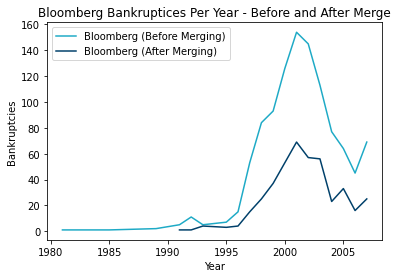

In [ ]:
#plt.plot(DLRSN_Analysis, label='DLRSN')
plt.plot(BloombergBeforeMergeAnalysis, label='Bloomberg (Before Merging)', color=(30/255,170/255,198/255,255/255))
#plt.title('Number of Firms in Universe'))
plt.plot(BloombergAfterMergeAnalysis, label='Bloomberg (After Merging)', color=(0,64/255,106/255,255/255))
#plt.plot(combinedIndicatorsAnalysis, label='Combined Indicator')
#plt.plot(paperData['bankruptcies'], label='Paper')
plt.xlabel("Year")
plt.ylabel("Bankruptcies")
plt.title('Bloomberg Bankruptices Per Year - Before and After Merge')
plt.legend()
plt.savefig('images/bloombergBeforeVsAfterMerge.png')
plt.show()

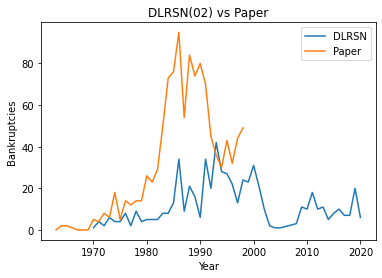

In [ ]:
plt.plot(DLRSN_Analysis, label='DLRSN')
#plt.plot(BloombergBeforeMergeAnalysis, label='Bloomberg (Before Merging)')
#plt.plot(BloombergAfterMergeAnalysis, label='Bloomberg (After Merging)')
#plt.plot(combinedIndicatorsAnalysis, label='Combined Indicator')
plt.plot(paperData['bankruptcies'], label='Paper')
plt.xlabel("Year")
plt.ylabel("Bankruptcies")
plt.title('DLRSN(02) vs Paper')
plt.legend()
plt.show()

In [ ]:
combinedIndicators.head()

,PERMNO,dlrsn,dldte,companyName,Effective Date,bankruptcyIndicator,dldte_month,Effective Date_month,bankruptcyDate
0,10000,10.0,1989-09-30,NaN,NaT,0,1989-09,NaT,1989-09
1,10000,10.0,1989-09-30,NaN,NaT,0,1989-09,NaT,1989-09
2,10000,10.0,1989-09-30,NaN,NaT,0,1989-09,NaT,1989-09
3,10000,10.0,1989-09-30,NaN,NaT,0,1989-09,NaT,1989-09
4,10000,10.0,1989-09-30,NaN,NaT,0,1989-09,NaT,1989-09


In [ ]:
newCombinedDataFrame = pd.merge(xDataFrame.copy(),
                                combinedIndicators.copy(),
                                how='left',
                                left_on=['PERMNO', 'date_month'],
                                right_on=['PERMNO', 'date_month'],
                                suffixes=('', '_y')
                             )
# Drop Duplicate Columns
newCombinedDataFrame.drop(newCombinedDataFrame.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
newCombinedDataFrame.shape

(2600008, 30)

In [ ]:
newCombinedDataFrame.isna().sum()

PERMNO                        0
date_month                    0
PRC                           0
SHROUT                        0
CFACPR                        0
atq                      703047
ceqq                     639051
cheq                     715688
ltq                      710412
niq                      519669
dlrsn                   1195856
dldte                   1195856
GVKEY                    499322
conm                     499322
SIGMA                    121945
vwretdSP500                   0
totvalSP500                   0
NITA                     716617
NIMTA                    714835
TLTA                     719064
TLMTA                    710412
EXRET                     73187
RSIZE                         0
CASHMTA                  716467
companyName             2556523
Effective Date          2556523
bankruptcyIndicator           0
dldte_month             1195856
Effective Date_month    2556523
bankruptcyDate          1193178
dtype: int64

In [ ]:
xDataFrame = xDataFrame.drop_duplicates(['PERMNO', 'date_month'])

In [ ]:
combinedIndicators.shape

(2600005, 10)

In [ ]:
combinedIndicators = combinedIndicators.drop_duplicates(['PERMNO', 'date_month'])

In [ ]:
newCombinedDataFrame = newCombinedDataFrame.drop(columns=['dldte', 'Effective Date', 'dldte_month', 'Effective Date_month', 'bankruptcyDate', 'companyName'])
newCombinedDataFrame.head()

,PERMNO,GVKEY,conm,date_month,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,SIGMA,dlrsn,bankruptcyIndicator
0,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-02,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,NaN,10.0,0
1,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-03,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,NaN,10.0,0
2,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-04,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,NaN,10.0,0
3,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-05,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,0.718449,10.0,0
4,10000,13007.0,OPTIMUM MANUFACTURING -CL A,1986-06,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,0.520684,10.0,0


In [ ]:
newCombinedDataFrame.dropna().shape

(35238, 20)

In [ ]:
newCombinedDataFrame[newCombinedDataFrame['bankruptcyIndicator'].isna()]

,PERMNO,GVKEY,conm,date_month,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,SIGMA,dlrsn,bankruptcyIndicator


In [ ]:
xDataFrame.dropna().shape

(1783479, 12)

In [ ]:
xDataFrame.isna().sum()

PERMNO               0
date_month           0
PRC                  0
SHROUT               0
CFACPR               0
atq             703047
ceqq            639051
cheq            715688
ltq             710412
niq             519669
dlrsn          1195856
dldte          1195856
GVKEY           499322
conm            499322
SIGMA           121945
vwretdSP500          0
totvalSP500          0
NITA            716617
NIMTA           714835
TLTA            719064
TLMTA           710412
EXRET            73187
RSIZE                0
CASHMTA         716467
dtype: int64

In [ ]:
len(xDataFrame[['PERMNO', 'cik']].dropna().drop_duplicates())

14568

In [ ]:
len(xDataFrame[['PERMNO', 'cik']].dropna().drop_duplicates().drop_duplicates(subset=['cik']))

14053

In [ ]:
test = xDataFrame[['PERMNO', 'cik']].dropna().drop_duplicates()
duplicateCIKCodes = test[test.duplicated(subset=['cik'])]['cik']

In [ ]:
AUDIT_CIKCodes = AUDIT_ANALYTICS['COMPANY_FKEY'].drop_duplicates()

In [ ]:
len(duplicateCIKCodes[duplicateCIKCodes.isin(list(AUDIT_CIKCodes))])

158

In [ ]:
AUDIT_ANALYTICS = pd.read_csv('Data/Original/AUDIT_ANALYTICS.csv')

def formatFileData(FILE_DATE):
  FILE_DATE = str(FILE_DATE)
  FILE_DATE = FILE_DATE[:4] + '-' + FILE_DATE[4:6] + '-' + FILE_DATE[6:8]
  return FILE_DATE

# Drop NAs (only three)
AUDIT_ANALYTICS = AUDIT_ANALYTICS.dropna(subset=['FILE_DATE'])

# Convert float to string readable date
AUDIT_ANALYTICS['FILE_DATE'] = AUDIT_ANALYTICS['FILE_DATE'].map(formatFileData)

# Convert to Datetime Object
AUDIT_ANALYTICS['FILE_DATE'] = pd.to_datetime(AUDIT_ANALYTICS['FILE_DATE'], format='%Y-%m-%d')

In [ ]:
bloombergData = pd.read_csv('Data/Bloomberg/Bloomberg_bankruptcies_COMPLETE.csv')
bloombergData.head()

,Unnamed: 0,Action Type,Security ID,Announce/Declared Date,Effective Date,Amd Flag,companyName,filingType
0,0,Bankruptcy Filing,AITTQ US Equity,6/4/1981,6/4/1981,N,Name: Airlift International Inc,Filing Type: Chapter 11
1,1,Bankruptcy Filing,RBLI US Equity,7/1/1985,7/1/1985,N,Name: Roblin Industries Inc,Filing Type: Liquidation
2,2,Bankruptcy Filing,RAY US Equity,3/10/1989,3/10/1989,Y,Name: Raytech Corp-Del,Filing Type: Chapter 11
3,3,Bankruptcy Filing,WJIM US Equity,12/27/1989,12/27/1989,N,Name: Jim Walter Corp,Filing Type: Chapter 11
4,4,Bankruptcy Filing,BKNEO US Equity,1/7/1991,1/7/1991,Y,Name: Bank of New England Corp,Filing Type: Chapter 7


In [ ]:
date = pd.to_datetime(bloombergData['Effective Date'])
print(date.min())
print(date.max())
print(bloombergData.shape)
print(bloombergData.isna().sum())

1981-06-04 00:00:00
2010-12-31 00:00:00
(38382, 8)
Unnamed: 0                0
Action Type               0
Security ID               0
Announce/Declared Date    0
Effective Date            0
Amd Flag                  0
companyName               0
filingType                0
dtype: int64


In [ ]:
print(CRSP_COMPUSTAT_MERGED.isna().sum())

GVKEY            0
LPERMNO          0
datadate         0
fyearq           0
fqtr           148
indfmt           0
consol           0
popsrc           0
datafmt          0
tic             23
cusip            0
conm             0
curcdq           0
datacqtr      1913
datafqtr       546
atq         181918
ceqq        159503
cheq        192516
ltq         186811
niq         102586
exchg            0
cik          77047
costat           0
conml            0
dlrsn       444315
sic            186
dldte       444315
dtype: int64
